# Lecture 32:  Logistic Regression Model Evaluation


[Acknowledgments Page](https://ds100.org/sp23/acks/)

In [80]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from scipy.optimize import minimize

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [81]:
# Formatting options

# Big font helper
def adjust_fontsize(size=None):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    if size != None:
        SMALL_SIZE = MEDIUM_SIZE = BIGGER_SIZE = size
    plt.rcParams['font.size'] = SMALL_SIZE
    plt.rcParams['axes.titlesize'] = SMALL_SIZE
    plt.rcParams['axes.labelsize'] = MEDIUM_SIZE
    plt.rcParams['xtick.labelsize'] = SMALL_SIZE
    plt.rcParams['ytick.labelsize'] = SMALL_SIZE
    plt.rcParams['legend.fontsize'] = SMALL_SIZE
    plt.rcParams['figure.titlesize'] = BIGGER_SIZE
    # plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    # plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    # plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    # plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    # plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    # plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    # plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
def savefig(fname):
    if not SAVE_FIGURES_FLAG:
        # Avoid memory overload
        return
    
    if not os.path.exists("images"):
        os.mkdir("images")
    fig = plt.gcf()
    fig.patch.set_alpha(0.0)
    plt.savefig(f"images/{fname}.png", bbox_inches = 'tight');
    
plt.rcParams['lines.linewidth'] = 3

plt.style.use('fivethirtyeight')
sns.set_context("talk")
sns.set_theme()
#sns.set()
adjust_fontsize(20)


SAVE_FIGURES_FLAG = False

---

## (Notebook setup) Obtaining the Data

For this lecture, we will use the same Wisconsin Breast Cancer Dataset from [scikit learn](http://scikit-learn.org/stable/datasets/index.html#breast-cancer-wisconsin-diagnostic-database). This is the same dataset we used in Lecture 23, so we'll skip the EDA analysis.

Classification task: Given the `mean radius` of tumor cells in an image, predict if the tumor is malignant (1) or benign (0).

In [82]:
import sklearn.datasets

# Load the data
data_dict = sklearn.datasets.load_breast_cancer()


# Data is a dictionary.
print(data_dict.keys())
print(data_dict.DESCR)

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these 

In [5]:

data = pd.DataFrame(data_dict['data'], columns=data_dict['feature_names'])
# Target data_dict['target'] = 0 is malignant 1 is benign
data['malignant'] = (data_dict['target'] == 0).astype(int)



<br/>

Before we go further, we will split our dataset into training and testing data. This lets us explore the prediction power of our trained classifier on both seen and unseen data.

In [83]:
# Split the data
from sklearn.model_selection import train_test_split
data_tr_val, data_te = train_test_split(data, test_size=0.20, random_state=42)
data_tr, data_val = train_test_split(data_tr_val, test_size=0.20, random_state=101)
data_tr.reset_index(inplace=True, drop=True)
data_te.reset_index(inplace=True, drop=True)
print("Training Data Size: ", len(data_tr))
print("Validation Data Size: ", len(data_val))
print("Test Data Size: ", len(data_te))

# X, Y are training data
X = data_tr[['mean radius']].to_numpy()
Y = data_tr['malignant'].to_numpy()

Training Data Size:  364
Validation Data Size:  91
Test Data Size:  114


<Figure size 288x288 with 0 Axes>

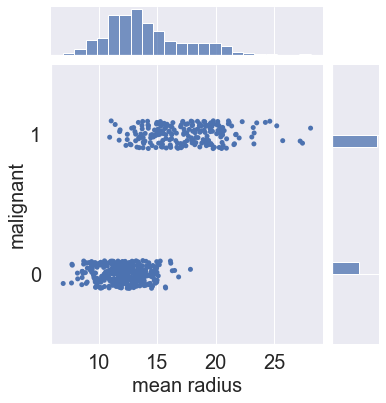

In [84]:
# Manual to allow for jitter
plt.figure(figsize=(4,4))
g = sns.JointGrid(data = data, x = "mean radius", y = "malignant")
g.plot_marginals(sns.histplot)
g.plot_joint(sns.stripplot,
             orient='h', order=[1, 0],
             color=sns.color_palette()[0])
(g.ax_joint).set_xticks([10, 15, 20, 25])
plt.show()

---

<br/><br/>

# sklearn

The `linear_model.LogisticRegression` model ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)) is what we want to use here. In order to recreate our specific model, there are a few parameters we need to set:
- by default, `LogisticRegression` uses regularization.  This is generally a good idea. The default is sklearn  a **l2 regularized** logistic regression model as specified in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) 
- `fit_intercept = False`: our toy model does not currently have an intercept term.
- `solver = 'lbgfs'`: need to specify a numerical optimization routine for the model (similar to gradient descent). `lbfgs` is one such type; it's the new default in `scikit-learn`.

<br/><br/>

### Fit

We'll fit a model with the mean radius feature and an intercept. So $\theta = (\theta_0, \theta_1)$ and our model is:

$$\hat{P}_{\theta} (Y = 1 | x) = \frac{1}{1+e^{-(\theta_0 + \theta_1 x_1)}}$$

In [85]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X, Y); # X, Y are training data

<br/>

Optimal $\theta_0, \theta_1$ from fitting our model:

In [86]:
model.intercept_, model.coef_

(array([-14.93961547]), array([[1.00841301]]))

<br/><br/>

### Prediction

<br/>

**Predict probabilities**: `scikit-learn` has a built-in `.predict_proba` method that allows us to get the predicted probabilities under our model. 

Check out the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba) for `lr.predict_proba()`.

The `.classes_` attribute stores our class labels.

In [87]:
model.predict_proba([[20]])

array([[0.0053322, 0.9946678]])

In [88]:
model.classes_

array([0, 1])

<br/><br/>

Let's visualize these probabilities on our train dataset, `X` and `y`.

In [89]:
Prob_hat_one = model.predict_proba(X)[:, 1]
print(Prob_hat_one.shape)

(364,)


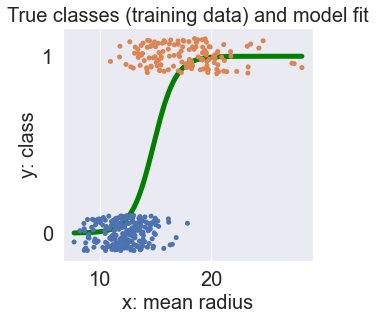

In [90]:
Prob_hat_one = model.predict_proba(X)[:, 1]

plt.figure(figsize=(4,4))
sns.stripplot(x=X.squeeze(), y=Y, 
              jitter = 0.1, orient='h');
sns.lineplot(x= X.squeeze(), y=Prob_hat_one,
             color='green', linewidth=5, label=r'$\hat{P}_{\theta}(Y = 1 | x)$')
plt.gca().invert_yaxis()
plt.xlabel('x: mean radius')
plt.ylabel('y: class')
plt.title("True classes (training data) and model fit")
plt.legend().remove()
savefig("true")

<br/>

**Predict class labels**: By comparison, what does `.predict()` do?

It predicts 1 if the computed probability for class 1 is greater than 0.5, and 0 otherwise.

$$\text{classify}(x) = \begin{cases} 1, & P(Y = 1 | x) \geq 0.5 \\ 0, & \text{otherwise} \end{cases}$$

This is what we call **classification**.


In [91]:
def threshold_plot(t, X, Y, Prob_hat_one):
    preds = (model.predict_proba(X)[:,1] >= t)
    fig = plt.figure()
    color_palette = {False:'red', True:'green'}
    fig = sns.stripplot(x=X.squeeze(), y=preds, 
              jitter = 0.1, orient='h', hue= preds==Y, 
              palette = color_palette);
    plt.gca().invert_yaxis()
    plt.xlabel('x: mean radius')
    plt.ylabel(r'$\hat{y}$: predicted class')
    plt.xlim((7, 30))
    plt.axhline(y=t, label='T = {}'.format(t))
    f = sns.lineplot(x= X.squeeze(), y=Prob_hat_one,
                 color='blue', linewidth=3)
    plt.setp(f.get_legend().get_texts(), fontsize='10');
    plt.title("Predicted classes if T = {}".format(t))
    plt.legend().remove()
    

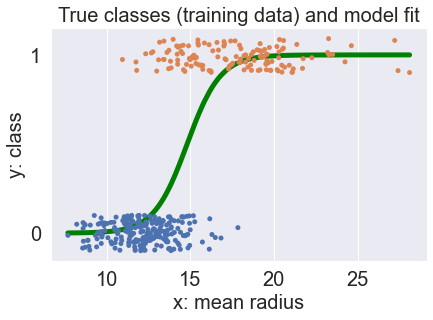

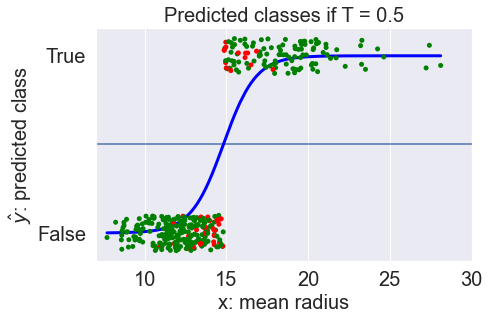

In [28]:

Prob_hat_one = model.predict_proba(X)[:, 1]


sns.stripplot(x=X.squeeze(), y=Y, 
              jitter = 0.1, orient='h');
sns.lineplot(x= X.squeeze(), y=Prob_hat_one,
             color='green', linewidth=5, label=r'$\hat{P}_{\theta}(Y = 1 | x)$')
plt.gca().invert_yaxis()
plt.xlabel('x: mean radius')
plt.ylabel('y: class')
plt.title("True classes (training data) and model fit")
plt.legend().remove()




threshold_plot(0.5, X,Y,  Prob_hat_one)

Edit the cell below to see sklearn's prediction for a mean radius of `10`.

In [92]:
model.predict([[10]])

array([0])

Visualizing how the model behaves on validation set:

In [93]:
# val accuracy:


X_val = data_val[['mean radius']].to_numpy()
Y_val = data_val['malignant'].to_numpy()


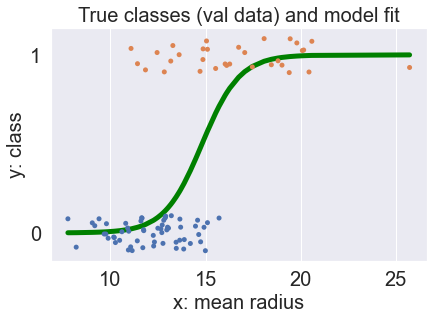

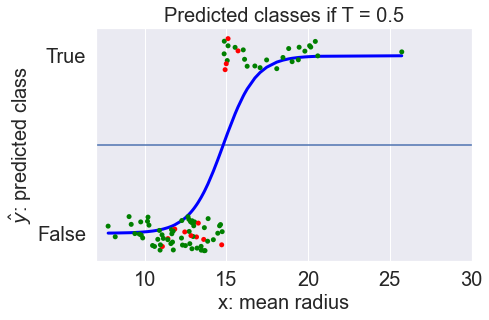

In [29]:
Prob_hat_val = model.predict_proba(X_val)[:, 1]


sns.stripplot(x=X_val.squeeze(), y=Y_val, 
              jitter = 0.1, orient='h');
sns.lineplot(x= X_val.squeeze(), y=Prob_hat_val,
             color='green', linewidth=5, label=r'$\hat{P}_{\theta}(Y = 1 | x)$')
plt.gca().invert_yaxis()
plt.xlabel('x: mean radius')
plt.ylabel('y: class')
plt.title("True classes (val data) and model fit")
plt.legend().remove()




threshold_plot(0.5, X_val, Y_val, Prob_hat_val)

# What if we adjust the threshold?

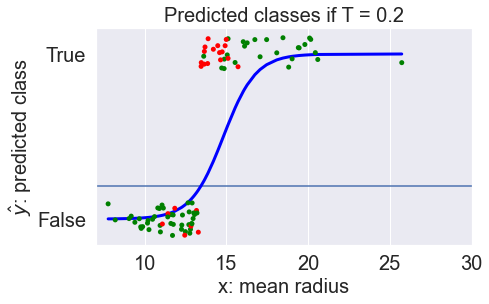

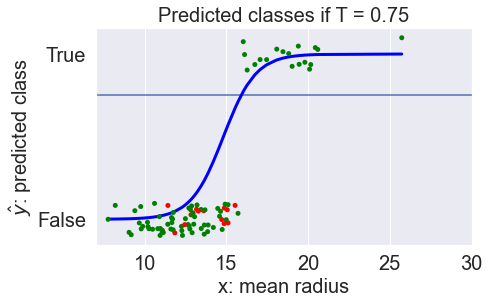

In [79]:

threshold_plot(0.20, X_val, Y_val, Prob_hat_val)
threshold_plot(0.75, X_val, Y_val, Prob_hat_val)

<br/><br/>

Let's build a DataFrame to store this information. We may need it later.

In [94]:
# In case you want to see all of the probabilities and predictions
def make_prediction_df(X, Y, model):
    # Assume X has one feature and that model is already fit 
    Prob = model.predict_proba(X)
    Y_hat = model.predict(X)
    df = pd.DataFrame({"X": X.squeeze(),
                       "Y": Y,
                       "P(Y = 1 | x)": Prob[:,1],
                       "Y_hat": Y_hat})
    return df
    
predict_train_df = make_prediction_df(X, Y, model)
predict_train_df

,X,Y,P(Y = 1 | x),Y_hat
0,11.800,0,0.045636,0
1,17.020,1,0.902347,1
2,9.683,0,0.005624,0
3,10.950,1,0.019889,0
4,19.440,1,0.990659,1
...,...,...,...,...
359,15.000,0,0.546510,1
360,12.880,0,0.124416,0
361,15.500,1,0.666142,1
362,21.100,1,0.998235,1


---

<br/><br/>

# Performance Metric

Recall that sklearn's `model.predict()` will predict 1 if $P(Y = 1 | x) \geq 0.5$, and 0 otherwise.

<br/>

First, let's compute the **accuracy** of our `model` on our **training** dataset.



In [95]:
def accuracy(X, Y):
    return np.mean(model.predict(X) == Y)


In [96]:
# training accuracy

print("Training set accuracy:",accuracy(X, Y))

Training set accuracy: 0.8763736263736264


Next, let's compute the **accuracy** of our `model` on our **validation** dataset.


In [97]:



print("Validation set accuracy:",accuracy(X_val, Y_val))

Validation set accuracy: 0.8571428571428571


As per usual, `scikit-learn` can do this for us. The `.score` method of a `LogisticRegression` classifier gives us the accuracy of it.

In [98]:
# Accuracy for training set:
model.score(X, Y)

0.8763736263736264

### Precision and Recall


It seems we can get a very high accuracy. What about precision and recall?  
- **Precision** (also called positive predictive value) is the fraction of true positives among the total number of data points predicted as positive.  
- **Recall** (also known as sensitivity) is the fraction of true positives among the total number of data points with positive labels.

Precision measures the ability of our classifier to not predict negative samples as positive (i.e., avoid false positives), while recall is the ability of the classifier to find all the positive samples (i.e., avoid false negatives).

Below is a graphical illustration of precision and recall, modified slightly from [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall):
![precision_recall](precision_recall.png)

Mathematically, Precision and Recall are defined as:
$$
\text{Precision} = \frac{n_{true\_positives}}{n_{true\_positives} + n_{false\_positives}} = \frac{TP}{TP+FP}
$$

$$
\text{Recall} = \frac{n_{true\_positives}}{n_{true\_positives} + n_{false\_negatives}}=\frac{TP}{TP+FN}
$$

Use the formulas above to compute the precision and recall for the **test set** using the `lr` model trained using sklearn.

In [100]:
Y_hat_val = model.predict(X_val)
tp = np.sum((Y_hat_val == 1) & (Y_val == 1))
tn = np.sum((Y_hat_val == 0) & (Y_val == 0))

fp = np.sum((Y_hat_val == 1) & (Y_val == 0))
fn = np.sum((Y_hat_val == 0) & (Y_val == 1))
tp, tn, fp, fn

(23, 55, 4, 9)

In [101]:
precision = tp / (tp + fp)
precision

0.8518518518518519

In [102]:
recall = tp / (tp + fn)
recall

0.71875

It's important to remember that these values are all for the threshold of $T = 0.5$, which is `scikit-learn`'s default.

## Confusion matrix and Built-In Scipy Functions to Calculate Precision and Recall

Our good old friend `scikit-learn` has an in-built confusion matrix method (of course it does).

In [103]:
from sklearn.metrics import confusion_matrix

# Be careful – confusion_matrix takes in y_true as the first parameter and y_pred as the second.
# Don't mix these up!
cm = confusion_matrix(Y_val, model.predict(X_val))
cm

array([[55,  4],
       [ 9, 23]])

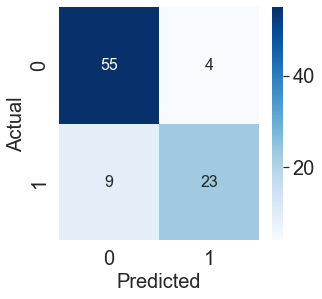

In [104]:

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'Blues', annot_kws = {'size': 16})
plt.xlabel('Predicted')
plt.ylabel('Actual');
savefig("cm")

In [ ]:
from sklearn.metrics import precision_score

precision_score(Y_val, Y_hat_val)

In [ ]:
from sklearn.metrics import recall_score
recall_score(Y_val, Y_hat_val)

These numbers match what we calculated manually  above.

---

<br/><br/>

# Adjusting the Classification Threshold

What does a prediction of 1 mean with the default sklearn threshold of $T = 0.5$?

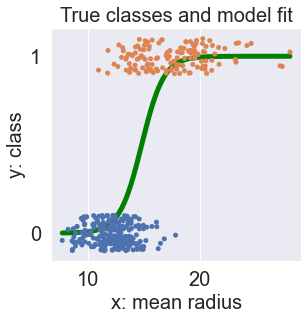

In [35]:
Prob_hat_one = model.predict_proba(X)[:, 1]

plt.figure(figsize=(4,4))
sns.stripplot(x=X.squeeze(), y=Y, 
              jitter = 0.1, orient='h');
sns.lineplot(x= X.squeeze(), y=Prob_hat_one,
             color='green', linewidth=5, label=r'$\hat{P}_{\theta}(Y = 1 | x)$')
plt.gca().invert_yaxis()
plt.xlabel('x: mean radius')
plt.ylabel('y: class')
plt.title("True classes and model fit")
plt.legend().remove()
savefig("true")

What if we choose different thresholds?

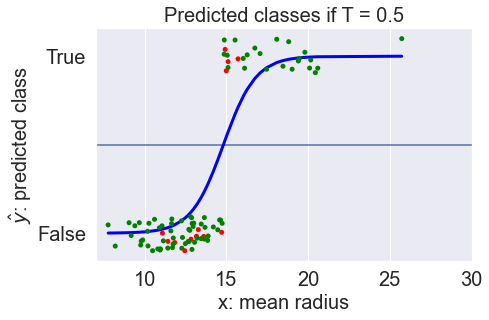

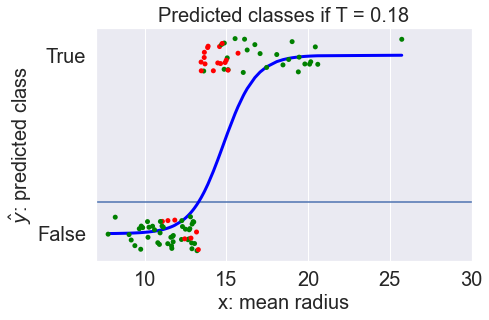

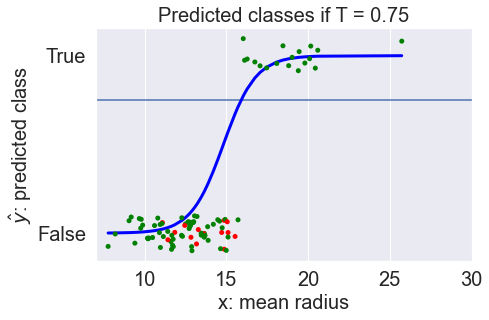

<br/><br/>

# Choosing a Threshold

What is the best threshold for a given performance metric?

This depends on what we're using the data for.

Since we're building are building a classifier to identify tumors, we want to make sure that we don’t miss any malignant tumors. Conversely, we’re less concerned about classifying a benign tumor as malignant because a pathologist would still need to take a closer look to verify the malignant classification. In this case, we want to have a high true positive rate among the records that are actually positive, i.e., we're more concerned with having a high rate of sensitivity/recall. 

<br/><br/>

## Precision vs Recall


In [40]:
from sklearn import metrics
precision, recall, threshold = (
    metrics.precision_recall_curve(Y_val, model.predict_proba(X_val)[:, 1]))

tpr_df = pd.DataFrame({"threshold":threshold, 
                       "precision":precision[:-1], "recall": recall[:-1], })


In [42]:
%matplotlib inline

fig = go.Figure()
              
fig.add_trace(go.Scatter(x=tpr_df["threshold"], y=tpr_df["precision"], name="Precision"))

fig.add_trace(go.Scatter(x=tpr_df["threshold"], y=tpr_df["recall"], name="Recall",
                         line=dict(dash='dash')))

fig.update_layout(width=550, height=550, 
                  xaxis_title="Threshold", yaxis_title="Proportion")
fig


## ROC Curves

<br/><br/>



This is the curve of False Positive vs True Positive for different thresholds.  

To start, we'll plot the TPR and FPR rates vs. threshold:

In [68]:
bc_model = model        # Fit to breast cancer dataset
def predict_threshold(model, X, T): 
    prob_one = model.predict_proba(X)[:, 1]
    return (prob_one >= T).astype(int)


def tpr_threshold(X, Y, T): # This is recall
    Y_hat = predict_threshold(bc_model, X, T)
    return np.sum((Y_hat == 1) & (Y == 1)) / np.sum(Y == 1)

def fpr_threshold(X, Y, T):
    Y_hat = predict_threshold(bc_model, X, T)
    return np.sum((Y_hat == 1) & (Y == 0)) / np.sum(Y == 0)


In [70]:
# Compute for different thresholds on train set
thresholds = np.linspace(0, 1, 100)
tprs = [tpr_threshold(X_val, Y_val, t) for t in thresholds]
fprs = [fpr_threshold(X_val, Y_val, t) for t in thresholds]

In [56]:
fig = go.Figure()
fig.add_trace(go.Scatter(name = 'TPR', x = thresholds, y = tprs))
fig.add_trace(go.Scatter(name = 'FPR', x = thresholds, y = fprs))
fig.update_xaxes(title="Threshold")
fig.update_yaxes(title="Proportion")

Some observations:
* T = 0 means everything is positive.
    * Then there are no TN (all of them are FP). → FPR = 1
    * We identified all true 1’s as 1, so TPR = recall = 1
* T = 1 means everything is negative.
    * Then there are no FP (all of them are TN). → FPR = 0
    * We identified zero true 1’s as 1, so TPR = recall = 0

In other words, TPR and FPR are both inversely proportional to the classification threshold T.

As we increase T, both TPR and FPR decrease.
* A decreased TPR is bad (detecting fewer positives).
* A decreased FPR is good (fewer false positives).



## Putting this all together: ROC curve


In [71]:
fig = px.line(x=fprs, y = tprs, hover_name=thresholds, title="ROC Curve")
fig.update_xaxes(title="False Positive Rate")
fig.update_yaxes(title="True Positive Rate")
fig

 We can measure how "good" this curve is using the Area Under the Curve.  The closer this number is to 1, the "better" this  model is.  
 


In [72]:

metrics.roc_auc_score(Y_val, model.predict_proba(X_val)[:, 1])



0.8800317796610171


## Accuracy

Accuracy threshold prediction on the validation set:

In [58]:
bc_model = model        # Fit to breast cancer dataset
def predict_threshold(model, X, T): 
    prob_one = model.predict_proba(X)[:, 1]
    return (prob_one >= T).astype(int)

def accuracy_threshold(X, Y, T):
    return np.mean(predict_threshold(bc_model, X, T) == Y)

In [66]:
# Compute accuracies for different thresholds on validation set
thresholds = np.linspace(0, 1, 100)
accs = [accuracy_threshold(X_val, Y_val, t) for t in thresholds]


fig = px.line(x=thresholds, y=accs, title="Train Accuracy vs. Threshold")
fig.update_xaxes(title="threshold")
fig.update_yaxes(title="Accuracy")

In [60]:
# The threshold that maximizes accuracy
np.argmax(accs)

46

<br/>
<br/>

In practice we should use cross validation. (We'll do this on the entire train/val set:)

In [61]:
X_tr_val = data_tr_val[['mean radius']].to_numpy()
Y_tr_val = data_tr_val['malignant'].to_numpy()

In [62]:
from sklearn import metrics

# Used for sklearn's cross_val_score
def make_scorer(metric, T):
    return lambda model, X, Y: metric(Y_tr_val, predict_threshold(model, X_tr_val, T)) 

def acc_scorer(T):
    return make_scorer(metrics.accuracy_score, T)

In [75]:
from sklearn.model_selection import cross_val_score
cv_accs = [
    np.mean(cross_val_score(bc_model, X_tr_val, Y_tr_val, 
                            scoring=acc_scorer(t), 
                            cv=5))
    for t in thresholds
]

In [64]:
fig = px.line(x=thresholds, y=cv_accs, title="Cross-Validated Accuracy vs. Threshold")
fig.update_xaxes(title="threshold")
fig.update_yaxes(title="Accuracy")

In [65]:
# The threshold that maximizes cross-validation accuracy
np.argmax(cv_accs)

54

## Precision-Recall Curves



`scikit-learn` can also do this for us.

In [73]:
from sklearn.metrics import precision_recall_curve

In [76]:
precision, recall, threshold = precision_recall_curve(Y_val, bc_model.predict_proba(X_val)[:, 1])

In [77]:
fig = px.line(x=recall[:-1], y=precision[:-1], hover_name=threshold)
fig.update_xaxes(title="Recall")
fig.update_yaxes(title="Precision")

---

<br/><br/>

# Linear Separability and the Need for Regularization


Suppose we had the following toy data:

In [ ]:
toy_df = pd.DataFrame({"x": [-1, 1], "y": [1, 0]})
#plt.scatter(toy_df['x'], toy_df['y'], s=100);
sns.scatterplot(data=toy_df, x='x', y='y',
              s=100, legend=None);

Let's look at the mean cross-entropy loss surface for this toy dataset, and a single feature model $\hat{y} = \sigma(\theta x)$.



Let's consider a simplified logistic regression model of the form:

$$ \Large \hat{P}_{\theta}(Y = 1 | x) = \sigma(\theta_1 x) = \frac{1}{1 + e^{-\theta_1 x}} $$

With mean cross-entropy loss:

\begin{align}
\hat{\theta} &= \underset{\theta}{\operatorname{argmin}}  - \frac{1}{n} \sum_{i=1}^n \left( y_i \log (\sigma(\theta_1 x_i) + (1 - y_i) \log (1 - \sigma(\theta_1 x_i)) \right) \\
&= \underset{\theta}{\operatorname{argmin}} -\frac{1}{2} \left[ \log (\sigma( -  \theta_1 )) + \log(1 - \sigma(\theta_1))\right]
\end{align}

In [ ]:
def toy_model(theta1, x):
    return 1/(1 + np.exp(-theta1 * x))

def mean_cross_entropy_loss_toy(theta1):
    # Here we use 1 - sigma(z) = sigma(-z) to improve numerical stability
    return - np.sum(toy_df['y'] * np.log(toy_model(theta1, toy_df['x'])) + \
                    (1-toy_df['y']) * np.log(toy_model(theta1, -toy_df['x'])))

In [ ]:
thetas = np.linspace(-30, 30, 100)
plt.plot(thetas, [mean_cross_entropy_loss_toy(theta) for theta in thetas], color = 'green')
plt.ylabel(r'MCE($\theta$)')
plt.xlabel(r'$\theta$');
plt.title("No regularization")

But using **regularization**:

In [ ]:
def mce_regularized_loss_single_arg_toy(theta, reg):
    return mce_loss_single_arg_toy(theta) + reg * theta**2 

def regularized_loss_toy(theta1, reg):
    return mean_cross_entropy_loss_toy(theta1) + reg * theta1**2

thetas = np.linspace(-30, 30, 100)
plt.plot(thetas, [regularized_loss_toy(theta, 0.1) for theta in thetas], color = 'green')
plt.ylabel(r'MCE($\theta$) + 0.1 $\theta^2$')
plt.xlabel(r'$\theta$');
plt.title(r"Mean Loss + L2 Regularization ($\lambda$ = 0.1)")

### Linearly separable plots

In case you were curious about how we generated the linearly separable plots for lecture.

In [ ]:
# Change y_sep vs y_nosep
y_used = 'y_sep'

data_1d = pd.DataFrame(
    {"x": [-1, -.75, -.5, -.25, .3, .4, 1, 1.2, 3],
     "y_sep": [ 1,    1,   1,   1,   0,  0, 0, 0,   0],
     "y_nosep": [1,   0,   1,   0,   0,  0, 0, 0,   0]
    })

plt.figure(figsize=((6.1, 1.5)))
sns.scatterplot(data=data_1d, x='x', y=y_used,hue=y_used,
              s=100, edgecolor='k', linewidth=1, legend=None);
plt.ylim((-.3, 1.25))
plt.yticks([0, 1])
sns.rugplot(data=data_1d, x='x', hue=y_used, height = 0.1, legend=None, linewidth=4);
plt.ylabel("y");

In [ ]:
iris = sns.load_dataset('iris')

plt.figure(figsize=(6, 4))
# Separable
sns.scatterplot(data = iris[iris['species'] != 'virginica'],
               x = 'petal_length',
               y = 'petal_width',
               hue = 'species', s=100);
plt.gca().legend_.set_title(None)

And the following here is not:

In [ ]:
# Not separable
plt.figure(figsize=(6, 4))
sns.scatterplot(data = iris[iris['species'] != 'setosa'],
               x = 'petal_length',
               y = 'petal_width',
               palette=sns.color_palette()[1:3],
               hue = 'species', s=100);
plt.gca().legend_.set_title(None)

# Regularization Demo

As a demo of the model fitting process from end-to-end, let's fit a regularized LogisticRegression model on the `iris` data, while performing a train/test split.

Let's try and predict the species of our `iris`. But, there are three possible values of `species` right now:

In [ ]:
iris = sns.load_dataset('iris')
iris['species'].unique()

So let's create a new column `is_versicolor` that is 1 if the iris is a versicolor, and a 0 otherwise.

In [ ]:
iris['is_versicolor'] = (iris['species'] == 'versicolor').astype(int)

In [ ]:
iris

In [ ]:
cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import random

random.seed(25)
iris_train, iris_test = train_test_split(iris, test_size = 0.2)

First, let's look at the coefficients if we fit without regularization:

In [ ]:
iris_model_no_reg = LogisticRegression(penalty = 'none', solver = 'lbfgs')
iris_model_no_reg.fit(iris_train[cols], iris_train['is_versicolor'])

In [ ]:
iris_model_no_reg.coef_

In [ ]:
iris_model_no_reg.intercept_

Now let's fit with regularization, using the default value of `C` (the regularization hyperparameter in `scikit-learn`):

In [ ]:
iris_model_reg = LogisticRegression(penalty = 'l2', solver = 'lbfgs')
iris_model_reg.fit(iris_train[cols], iris_train['is_versicolor'])

In [ ]:
iris_model_reg.coef_

In [ ]:
iris_model_reg.intercept_

We can see the coefficients on the regularized model are significantly smaller.

Let's evaluate the training and testing accuracy of both models – regularized and not.

In [ ]:
iris_model_no_reg.score(iris_train[cols], iris_train['is_versicolor'])

In [ ]:
iris_model_reg.score(iris_train[cols], iris_train['is_versicolor'])

Unsurprisingly, the regularized model performs worse on the training data.

In [ ]:
iris_model_no_reg.score(iris_test[cols], iris_test['is_versicolor'])

In [ ]:
iris_model_reg.score(iris_test[cols], iris_test['is_versicolor'])

In this case, they both happened to perform the same on the test data. Interesting!

**Question:** What did we forget to do here (that we should always do when performing regularized linear or logistic regression)?